In [1]:
! nvidia-smi

Fri Oct 11 20:20:30 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 552.22                 Driver Version: 552.22         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA RTX A4000             WDDM  |   00000000:01:00.0  On |                  Off |
| 41%   44C    P8             18W /  140W |    1500MiB /  16376MiB |      1%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
#텐서 플로  GPU 설치
! pip install tensorflow-gpu==2.10.0

In [13]:
!pip uninstall numpy -y

Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Successfully uninstalled numpy-1.26.4


You can safely remove it manually.
You can safely remove it manually.


In [14]:
!pip install numpy==1.23.5

  Using cached numpy-1.23.5-cp310-cp310-win_amd64.whl.metadata (2.3 kB)
Using cached numpy-1.23.5-cp310-cp310-win_amd64.whl (14.6 MB)


In [15]:
!pip uninstall scipy -y

In [16]:
!pip install scipy

  Using cached scipy-1.14.1-cp310-cp310-win_amd64.whl.metadata (60 kB)


ERROR: Could not install packages due to an OSError: [Errno 2] No such file or directory: 'c:\\programdata\\anaconda3\\envs\\ai_project_env01\\lib\\site-packages\\numpy-1.26.4.dist-info\\METADATA'



In [7]:
! pip install matplotlib

ERROR: Could not install packages due to an OSError: [Errno 2] No such file or directory: 'c:\\programdata\\anaconda3\\envs\\ai_project_env01\\lib\\site-packages\\numpy-1.26.4.dist-info\\METADATA'



In [8]:
!pip install imgaug

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.python.client import device_lib

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [3]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 12199646827667538881
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14374928384
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 2779319171365984926
 physical_device_desc: "device: 0, name: NVIDIA RTX A4000, pci bus id: 0000:01:00.0, compute capability: 8.6"
 xla_global_id: 416903419]

In [12]:
#tf.debugging.set_log_device_placement(True)

In [4]:
TRAIN_DIR = 'C:/ai_project01/preprocessed_dataset/train/'
TEST_DIR = 'C:/ai_project01/preprocessed_dataset/test/'

In [5]:
IM_WIDTH = 224
IM_HEIGHT = 224

In [6]:
import imgaug.augmenters as iaa
import imgaug as ia
from imgaug import parameters as iap

In [7]:
from imgaug.augmenters.arithmetic import Invert
from imgaug.augmenters import size

# 전체 중에서 20% 확률로 적용
sometimes = lambda aug: iaa.Sometimes(0.2, aug)

#증강 함수들은  https://github.com/aleju/imgaug
#https://imgaug.readthedocs.io/_/downloads/en/latest/pdf/ 를 참조해서 구현하고 성능 테스트 해볼것

seq_train = iaa.Sequential([
                # apply the following augmenters to most images
                iaa.Fliplr(0.5), # horizontally flip 50% of all images
                iaa.Flipud(0.2), # vertically flip 20% of all images
                # crop images by -5% to 10% of their height/width
                sometimes(iaa.CropAndPad(
                    percent=(-0.05, 0.1),
                    pad_mode=ia.ALL,
                    pad_cval=(0, 255)
                )),
                sometimes(iaa.Affine(
                    scale={"x": (0.8, 1.2), "y": (0.8, 1.2)}, # scale images to 80-120% of their size, individually per axis
                    translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)}, # translate by -20 to +20 percent (per axis)
                    rotate=(-45, 45), # rotate by -45 to +45 degrees
                    shear=(-16, 16), # shear by -16 to +16 degrees
                    order=[0, 1], # use nearest neighbour or bilinear interpolation (fast)
                    cval=(0, 255), # if mode is constant, use a cval between 0 and 255
                    mode=ia.ALL # use any of scikit-image's warping modes (see 2nd image from the top for examples)
                )),
    
                sometimes( 
                    iaa.BlendAlphaFrequencyNoise(
                        #이미지에 0.5 ~ 1.5 사이 랜덤한 값을 곱해 줘서 색 변환
                        foreground=iaa.Multiply(iap.Choice([0.5, 1.5]), per_channel=True)
                    )
                )
                    ,
                     sometimes( 
                         #이미지를 흐리게 만들어서 선명하지 않은 경우에도 분류 가능하도록 학습 시킴
                         iaa.GaussianBlur(sigma=(0, 0.5))
                    ),
             # execute 0 to 5 of the following (less important) augmenters per image
        # don't execute all of them, as that would often be way too strong
        iaa.SomeOf((0, 5),
            [
                sometimes(iaa.Superpixels(p_replace=(0, 1.0), n_segments=(20, 200))), # convert images into their superpixel representation
                iaa.OneOf([
                    iaa.GaussianBlur((0, 3.0)), # blur images with a sigma between 0 and 3.0
                    iaa.AverageBlur(k=(2, 7)), # blur image using local means with kernel sizes between 2 and 7
                    iaa.MedianBlur(k=(3, 11)), # blur image using local medians with kernel sizes between 2 and 7
                ]),
                iaa.Sharpen(alpha=(0, 1.0), lightness=(0.75, 1.5)), # sharpen images
                iaa.Emboss(alpha=(0, 1.0), strength=(0, 2.0)), # emboss images
                # search either for all edges or for directed edges,
                # blend the result with the original image using a blobby mask
                iaa.SimplexNoiseAlpha(iaa.OneOf([
                    iaa.EdgeDetect(alpha=(0.5, 1.0)),
                    iaa.DirectedEdgeDetect(alpha=(0.5, 1.0), direction=(0.0, 1.0)),
                ])),
                iaa.Grayscale(alpha=(0.0, 1.0)),
                
            ])
        ],random_order=True #랜덤한 순서로 적용
    )


C:\ProgramData\anaconda3\envs\ai_project_env01\lib\site-packages\imgaug\imgaug.py:184: DeprecationWarning: Function `SimplexNoiseAlpha()` is deprecated. Use `BlendAlphaSimplexNoise` instead. SimplexNoiseAlpha is deprecated. Use BlendAlphaSimplexNoise instead. The order of parameters is the same. Parameter 'first' was renamed to 'foreground'. Parameter 'second' was renamed to 'background'.
  warn_deprecated(msg, stacklevel=3)


In [8]:
#ImageDataGenerator에서 실행 할 함수
#읽은 이미지가 매개변수 img에 저장
def img_preprocessing_train(img):
    #이미지의 모양을 3차원으로 변환
    #(이미지 개수, 이미지가로, 이미지 세로, 컬러)
    img = img.reshape(1, img.shape[0], img.shape[1], 3)
    #imgaug는 정수 이미지만 증강이 가능하기 때문에 이미지를 정수로 변환
    img = img.astype(np.uint8)
    #이미지를 증강 시키고 결과를 generate_img에 저장
    generate_img = seq_train(images=img)  
    #generate_img를 255로 나눠서 0~1사이 실수로 변환
    generate_img = generate_img /255
    #generate_img.reshape(이미지세로, 이미지가로, 컬러) : ImageDataGenerate에서 처리 가능하도록 이미지를 2차원 배열로 변환
    #.astype(np.float32) : 케라스가 처리 가능하도록 이미지를 float32 타입으로 변환
    return generate_img.reshape(IM_HEIGHT, IM_WIDTH, 3).astype(np.float32)

In [9]:
with tf.device('/GPU:0'):
   #학습에 사용될 이미지를 읽을 객체

    # 실행할때마다 변형된 이미지를 리턴해서 
    #이미지가 많은것 같은 효과를 줌
    train_datagen = ImageDataGenerator(
          rotation_range=180, # 회전 쵀대 180도
          width_shift_range=0.2, # 좌우 이동 최대 이미지 가로사이즈 20%
          height_shift_range=0.2, # 상하 이동 최대 이미지  세로사이즈 20%
          horizontal_flip=True, # 좌우 반전 실행
          vertical_flip=True, # 상하 반전 실행 
          #rescale=1/255.0, #imgaug는 정수 이미지를 증강 가능 하기 때문에 주석처리
          brightness_range=[0.5,1.2],  #이미지 밝기 조정 0 : 완전 어두운 이미지  1: 원본 밝기 0.5: 원본 50% 밝기1.2 : 원본보다 20% 밝은 이미지
          zoom_range=[0.8, 1.2] ,     #이미지 확대 0.8: 원본 80% 확대  1.2 : 원본 120% 확대
          preprocessing_function=img_preprocessing_train
          )
    
    train_generator = train_datagen.flow_from_directory(
        TRAIN_DIR,
        target_size=(IM_HEIGHT, IM_WIDTH),
        class_mode='categorical',
        shuffle=True
    )
    
    test_datagen = ImageDataGenerator(
        rescale=1/255.0
    )
    
    test_generator = train_datagen.flow_from_directory(
        TEST_DIR,
        target_size = (IM_HEIGHT,IM_WIDTH),
        class_mode='categorical'
    )



Found 7260 images belonging to 3 classes.
Found 1800 images belonging to 3 classes.


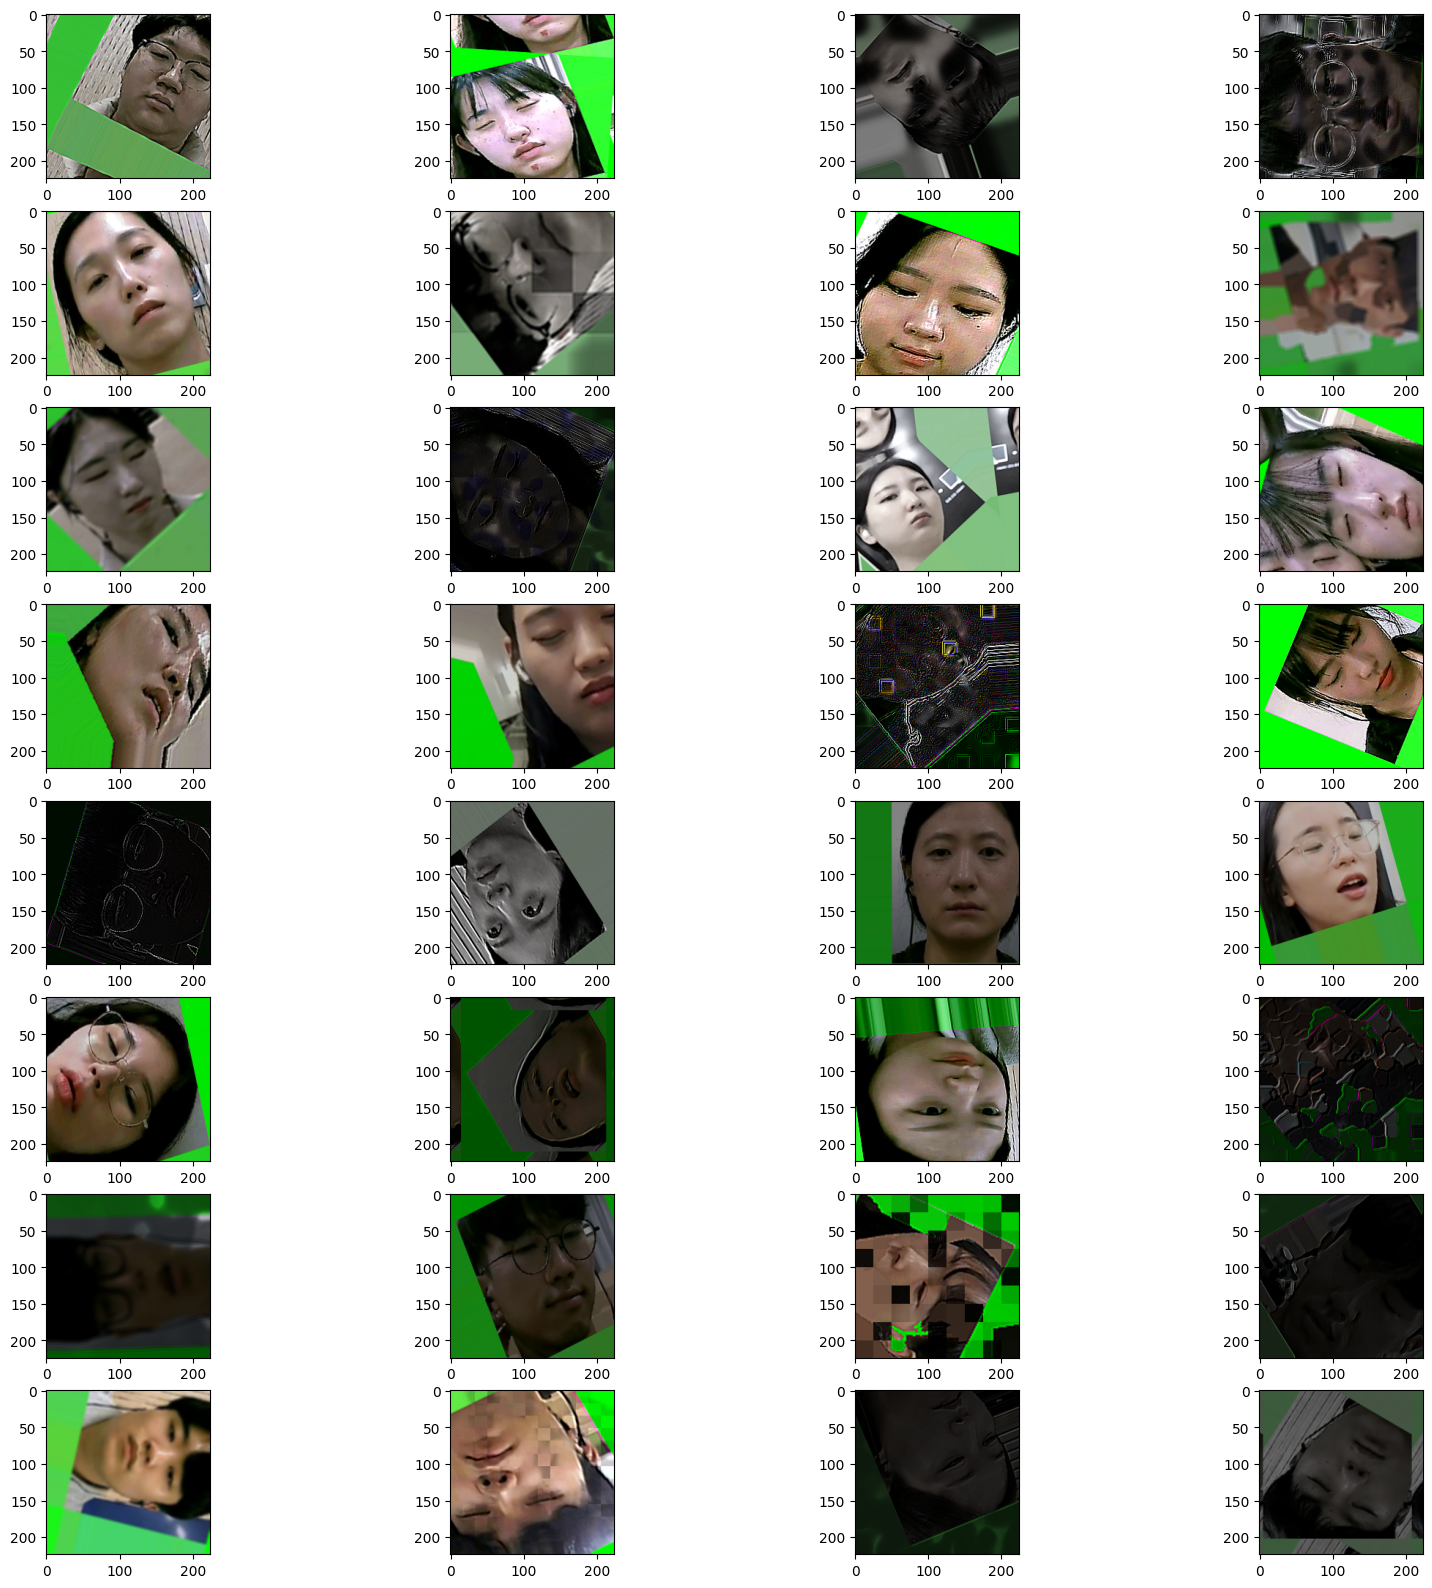

In [10]:
plt.figure(figsize=(20,20))
for i in range(32):
    data = next(train_generator)
    image = data[0]
    plt.subplot(8,4,i+1)
    plt.imshow(np.array(image[i]))
plt.show()

In [11]:
train_generator.class_indices

{'boring': 0, 'focus_on': 1, 'sleeping': 2}

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.optimizers import Adam



In [13]:
with tf.device('/GPU:0'):
    conv_layers = ResNet50V2(
        weights='imagenet',
        include_top=False,
        input_shape=(IM_HEIGHT,IM_WIDTH,3)
    )
    
    # for layer in conv_layers.layers:
    #     layer.trainable=False
    
    model = Sequential()
    
    model.add(conv_layers)
    
    model.add(Flatten())
    
    model.add(Dense(512, activation="relu"))
    
    model.add(Dropout(0.5) )
    
    model.add(Dense(256, activation="relu"))
    
    model.add(Dropout(0.5) )
    
    model.add(Dense(128, activation="relu"))
    
    model.add(Dropout(0.5) )
    
    model.add(Dense(3, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy', metrics=['acc'], optimizer=Adam(learning_rate=1e-4) )

94668760/94668760 [==============================] - 4s 0us/step


C:\ProgramData\anaconda3\envs\ai_project_env01\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [14]:
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping 

In [15]:
with tf.device('/GPU:0'):
    cb_checkpoint = ModelCheckpoint(filepath="c:/ai_project01/ab_result_Resnet/",
                                    monitor='val_acc',
                                    save_best_only=True
                                   )
    
    earlystopping = EarlyStopping(monitor='val_loss',
                                  patience=100,
                                 )
    
    
    

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 512)               51380736  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               3

In [17]:
model.fit(
           train_generator,
        epochs=1000,
        validation_data=test_generator,
        callbacks=[cb_checkpoint, earlystopping],
        batch_size = 64
        
              )

Epoch 1/1000
227/227 [==============================] - 136s 598ms/step - loss: 0.1490 - acc: 0.9478 - val_loss: 0.2344 - val_acc: 0.9183
Epoch 2/1000
227/227 [==============================] - 119s 524ms/step - loss: 0.1534 - acc: 0.9450 - val_loss: 0.2067 - val_acc: 0.9250
Epoch 3/1000
227/227 [==============================] - 120s 528ms/step - loss: 0.1556 - acc: 0.9453 - val_loss: 0.2105 - val_acc: 0.9267
Epoch 4/1000
227/227 [==============================] - 119s 525ms/step - loss: 0.1458 - acc: 0.9478 - val_loss: 0.2541 - val_acc: 0.8983
Epoch 5/1000
227/227 [==============================] - 121s 532ms/step - loss: 0.1663 - acc: 0.9439 - val_loss: 0.3050 - val_acc: 0.8894
Epoch 6/1000
227/227 [==============================] - 117s 517ms/step - loss: 0.2012 - acc: 0.9317 - val_loss: 0.2828 - val_acc: 0.8850
Epoch 7/1000
227/227 [==============================] - 119s 521ms/step - loss: 0.1490 - acc: 0.9453 - val_loss: 0.2161 - val_acc: 0.9239
Epoch 8/1000
227/227 [============